# Training model

In [33]:
from pathlib import Path
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from itertools import combinations
import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
import lightgbm as lgb
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from submissions.external_data.estimator import _encode_dates, _merge_external_data
import utils.get_data as get_data

### Function submission kaggle

In [34]:
def submission_kaggle(model, X_final_test, original_index):
    y_pred = model.predict(X_final_test)
    print(y_pred)
    results = pd.DataFrame(
        dict(
            Id=original_index,
            log_bike_count=y_pred,
        )
    )
    results.to_csv("submission.csv", index=False)

    return results

## Read Data

In [35]:
def add_external_data(X):

    X = X.copy()

    # merge original data + external data
    merged_X_train_external_DATA = get_data._merge_external_data_weather(X)

    # merge original data + external data + holidays
    merged_X_train_external_HOLIDAYS = get_data._merge_holidays_week_end(
        merged_X_train_external_DATA)

    # merge original data + external data + holidays + data COVID
    merged_X_train_external_HOLIDAYS_COVID = get_data._merge_Curfews_lockdowns_COVID(
        merged_X_train_external_HOLIDAYS)
    merged_X_train_external_HOLIDAYS_COVID = get_data._merge_indicators_COVID(
        merged_X_train_external_HOLIDAYS_COVID)

    # merge original data + external data + holidays + data COVID + data accidents
    merged_X_train_external_HOLIDAYS_COVID_ACCIDENTS = get_data._merge_road_accidents(
        merged_X_train_external_HOLIDAYS_COVID)

    return merged_X_train_external_HOLIDAYS_COVID_ACCIDENTS

In [36]:
# Read data
X_train, y_train = get_data.get_train_data()
X_test, y_test = get_data.get_test_data()
X_final_test = get_data.get_final_test_data()

In [37]:
X_train_plus = add_external_data(X_train)
X_train_plus.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,ff,...,is_holiday,is_weekend,is_lockdown,is_curfew,hosp,rea,incid_rea,rad,Max_Grav_accidents,Count_accidents
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,1.6,...,False,0,False,False,293,42,3.0,6641,0.0,0.0
30,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2020-09-01 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,1.6,...,False,0,False,False,293,42,3.0,6641,0.0,0.0
31,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,1.6,...,False,0,False,False,293,42,3.0,6641,0.0,0.0
32,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2020-09-01 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,1.6,...,False,0,False,False,293,42,3.0,6641,0.0,0.0
33,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2020-09-01 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,1.6,...,False,0,False,False,293,42,3.0,6641,0.0,0.0


In [38]:
X_test_plus = add_external_data(X_test)
X_test_plus.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,counter_technical_id,latitude,longitude,ff,...,is_holiday,is_weekend,is_lockdown,is_curfew,hosp,rea,incid_rea,rad,Max_Grav_accidents,Count_accidents
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2021-08-10 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,1.9,...,False,0,False,False,284,84,6.0,21167,0.0,0.0
31,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2021-08-10 01:00:00,2018-12-07,Y2H19070373,48.840801,2.333233,1.9,...,False,0,False,False,284,84,6.0,21167,0.0,0.0
32,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2021-08-10 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,1.9,...,False,0,False,False,284,84,6.0,21167,0.0,0.0
33,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2021-08-10 01:00:00,2017-07-12,Y2H19027732,48.853720,2.357020,1.9,...,False,0,False,False,284,84,6.0,21167,0.0,0.0
34,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2021-08-10 01:00:00,2020-07-22,Y2H20073268,48.885290,2.326660,1.9,...,False,0,False,False,284,84,6.0,21167,0.0,0.0


In [39]:
X_final_test_plus = add_external_data(X_final_test)
X_final_test_plus.head()

,counter_id,counter_name,site_id,site_name,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,...,is_holiday,is_weekend,is_lockdown,is_curfew,hosp,rea,incid_rea,rad,Max_Grav_accidents,Count_accidents
0,100049407-353255860,152 boulevard du Montparnasse E-O,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,False,0,False,False,365,126,5.0,21675,0.0,0.0
43,100049407-353255859,152 boulevard du Montparnasse O-E,100049407,152 boulevard du Montparnasse,2021-09-10 01:00:00,2018-12-07,"48.840801,2.333233",Y2H19070373,48.840801,2.333233,...,False,0,False,False,365,126,5.0,21675,0.0,0.0
31,100036719-104036719,18 quai de l'Hôtel de Ville NO-SE,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,False,0,False,False,365,126,5.0,21675,0.0,0.0
32,100036719-103036719,18 quai de l'Hôtel de Ville SE-NO,100036719,18 quai de l'Hôtel de Ville,2021-09-10 01:00:00,2017-07-12,"48.85372,2.35702",Y2H19027732,48.853720,2.357020,...,False,0,False,False,365,126,5.0,21675,0.0,0.0
33,100063175-353277233,20 Avenue de Clichy NO-SE,100063175,20 Avenue de Clichy,2021-09-10 01:00:00,2020-07-22,"48.88529,2.32666",Y2H20073268,48.885290,2.326660,...,False,0,False,False,365,126,5.0,21675,0.0,0.0


##  Preprocessing

In [40]:
def _encode_dates(X):
    '''
    Splits the 'date' columns of the input DataFrame into several columns (year, month, day, weekday, hour)

    Parameters:
        X (pd.DataFrame): the dataframe to modify

    Returns:
        X (pd.DataFrame): the modified dataframe
    '''

    # Duplicate X to work on it
    X = X.copy()

    # Create new columns with date parts from X.date
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    X.drop(columns=["date"], inplace=True)
    return X

# Training

In [41]:
def get_RMSE_local(model, X_train, y_train, X_test, y_test):

    # Fit the pipeline on the training data
    model.fit(X_train, y_train)

    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate RMSE for training and test data
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f"Train set RMSE: {rmse_train:.2f}")
    print(f"Test set RMSE: {rmse_test:.2f}")

    return rmse_train, rmse_test

### Select features for training

In [42]:
fixed_features = ['date', "counter_name", "site_id", "t", "u", "rr3"]

not_fixed_features = ["counter_id", "counter_technical_id", "counter_installation_date",
                      'site_name'
                      'counter_installation_date',
                      'counter_technical_id',
                      'latitude',
                      'longitude',
                      'ff',  # the wind speed
                      'u',  # the humidity
                      'ssfrai',  # the fresh snowfall amount
                      'n',  # the amount of cloud cover
                      'vv',  # the visibility
                      'rr3',  # the precipitation amount over 3 hours
                      't',  # the temperature
                      'is_holiday',  # is holidays
                      'is_weekend',  # is week end
                      'is_lockdown',  # Lockdown for COVID
                      'is_curfew',  # Curfew for COVID
                      'hosp',  # Number of patients currently hospitalised for COVID-19
                      'rea',  # Number of patients currently in intensive care.
                      # Number of new patients admitted to intensive care in the last 24 hours.
                      'incid_rea',
                      'rad',  # Cumulative number of patients hospitalised for COVID-19 who have returned home due to an improvement in their state of health
                      'Max_Grav_accidents',  # The maximum severity of all cyclists accidents at a given hour
                      'Count_accidents'  # the number of accidents at a given hour in Paris
                      ]

chosen_not_fixed_features = ['latitude',
                             'longitude',
                             'ff',  # the wind speed
                             'ssfrai',  # the fresh snowfall amount
                             'n',  # the amount of cloud cover
                             'vv',  # the visibility
                             'rr3',  # the precipitation amount over 3 hours
                             'is_holiday',  # is holidays
                             'is_weekend',  # is week end
                             'is_lockdown',  # Lockdown for COVID
                             'is_curfew',  # Curfew for COVID
                             'hosp',  # Number of patients currently hospitalised for COVID-19
                             # Number of patients currently in intensive care.
                             'rea',
                             # Number of new patients admitted to intensive care in the last 24 hours.
                             'incid_rea',
                             'rad',  # Cumulative number of patients hospitalised for COVID-19 who have returned home due to an improvement in their state of health
                             'Max_Grav_accidents',  # The maximum severity of all cyclists accidents at a given hour
                             'Count_accidents'  # the number of accidents at a given hour in Paris
                             ]

chosen_fixed_features = ['ff',  # the wind speed
                         'n',  # the amount of cloud cover
                         'vv',  # the visibility
                         'is_holiday',  # is holidays
                         'is_weekend',  # is week end
                         'is_lockdown',  # Lockdown for COVID
                         'is_curfew',  # Curfew for COVID
                         'hosp',  # Number of patients currently hospitalised for COVID-19
                         # Number of patients currently in intensive care.
                         'rea',
                         # Number of new patients admitted to intensive care in the last 24 hours.
                         'incid_rea',
                         'rad',  # Cumulative number of patients hospitalised for COVID-19 who have returned home due to an improvement in their state of health
                         'Max_Grav_accidents',  # The maximum severity of all cyclists accidents at a given hour
                         'Count_accidents'  # the number of accidents at a given hour in Paris
                         ]

chosen_fixed_features = ['is_holiday', 'rea', 'rad', 'hosp']

chosen_variables = fixed_features + chosen_fixed_features


X_train_plus_chosen = X_train_plus[chosen_variables]
X_test_plus_chosen = X_test_plus[chosen_variables]
X_final_test_plus_chosen = X_final_test_plus[chosen_variables]

In [43]:
# Identifying continuous variables (float type or int with wide range)

# Initialize the scaler
scaler = StandardScaler()

X_train_plus_chosen_FI = _encode_dates(X_train_plus_chosen)
# X_train_plus_chosen_FI = pd.get_dummies(X_train_plus_chosen_FI, columns=['site_name'])
X_train_plus_chosen_FI = pd.get_dummies(
    X_train_plus_chosen_FI, columns=['counter_name'])
X_train_plus_chosen_FI = pd.get_dummies(
    X_train_plus_chosen_FI, columns=['site_id'])
# continuous_columns  = X_train_plus_chosen_FI.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
# X_train_plus_chosen_FI[continuous_columns] = scaler.fit_transform(X_train_plus_chosen_FI[continuous_columns])

X_test_plus_chosen_FI = _encode_dates(X_test_plus_chosen)
# X_test_plus_chosen_FI = pd.get_dummies(X_test_plus_chosen_FI, columns=['site_name'])
X_test_plus_chosen_FI = pd.get_dummies(
    X_test_plus_chosen_FI, columns=['counter_name'])
X_test_plus_chosen_FI = pd.get_dummies(
    X_test_plus_chosen_FI, columns=['site_id'])
# X_test_plus_chosen_FI[continuous_columns] = scaler.fit_transform(X_test_plus_chosen_FI[continuous_columns])

X_final_test_plus_chosen_FI = _encode_dates(X_final_test_plus_chosen)
# X_final_test_plus_chosen_FI = pd.get_dummies(X_final_test_plus_chosen_FI, columns=['site_name'])
X_final_test_plus_chosen_FI = pd.get_dummies(
    X_final_test_plus_chosen_FI, columns=['counter_name'])
X_final_test_plus_chosen_FI = pd.get_dummies(
    X_final_test_plus_chosen_FI, columns=['site_id'])
# X_final_test_plus_chosen_FI[continuous_columns] = scaler.fit_transform(X_final_test_plus_chosen_FI[continuous_columns])

In [44]:
params_060 = {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.01, 'max_bin': None, 'max_cat_threshold': None,
              'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 12, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 800, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'verbose': True, 'early_stopping': True}

Regressor = xgb.XGBRegressor(**params_060)

# Train model with selected features
Regressor.fit(X_train_plus_chosen_FI, y_train)

get_RMSE_local(Regressor, X_train_plus_chosen_FI,
               y_train, X_test_plus_chosen_FI, y_test)

C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [10:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [10:10:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.35
Test set RMSE: 0.48


(0.34729581292891026, 0.48165626261323463)

### GRIDSEARCH 

#### XGBOOST

In [52]:
n_estimators = 1300
learning_rate = 0.02
subsample = 0.7
max_depth = 12

In [60]:
from sklearn.model_selection import GridSearchCV, train_test_split

# Splitting for validation
X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(
    X_train_plus_chosen_FI, y_train, test_size=0.2, random_state=42)
# Initialize the XGBRegressor
Regressor = xgb.XGBRegressor(objective='reg:squarederror',
                             verbose=True,
                             early_stopping=True
                             )

# Define hyperparameter grid
param_grid = {
    'n_estimators': [1100, 1300, 1500],
    'learning_rate': [0.01, 0.02],
    'max_depth': [10, 12, 15],
    'min_child_weight': [3, 4, 5, 6, 7],
    'subsample': [subsample],
    'colsample_bytree': [i/10.0 for i in range(6, 10)],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

# Randomized search with cross-validation
randomized_search = RandomizedSearchCV(
    Regressor, param_grid, n_iter=150, cv=2, scoring='neg_mean_squared_error', verbose=True, n_jobs=-1)
randomized_search.fit(X_train_cv, y_train_cv, eval_set=[
                      (X_val_cv, y_val_cv)], verbose=True)

# Best estimator
best_regressor = randomized_search.best_estimator_

# Evaluate the model using your custom function
# Assuming get_RMSE_local_wt_pipe is your evaluation function
get_RMSE_local(best_regressor, X_train_plus_chosen_FI,
               y_train, X_test_plus_chosen_FI, y_test)

full_params = best_regressor.get_params()
print("Full Parameters of the Best Regressor:", full_params)

Fitting 2 folds for each of 150 candidates, totalling 300 fits
[0]	validation_0-rmse:1.64881


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [18:54:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[1]	validation_0-rmse:1.62259
[2]	validation_0-rmse:1.59589
[3]	validation_0-rmse:1.57080
[4]	validation_0-rmse:1.54528
[5]	validation_0-rmse:1.52027
[6]	validation_0-rmse:1.49592
[7]	validation_0-rmse:1.47238
[8]	validation_0-rmse:1.45019
[9]	validation_0-rmse:1.42736
[10]	validation_0-rmse:1.40510
[11]	validation_0-rmse:1.38336
[12]	validation_0-rmse:1.36351
[13]	validation_0-rmse:1.34373
[14]	validation_0-rmse:1.33090
[15]	validation_0-rmse:1.31087
[16]	validation_0-rmse:1.29130
[17]	validation_0-rmse:1.27277
[18]	validation_0-rmse:1.25495
[19]	validation_0-rmse:1.23746
[20]	validation_0-rmse:1.22002
[21]	validation_0-rmse:1.20263
[22]	validation_0-rmse:1.18658
[23]	validation_0-rmse:1.17061
[24]	validation_0-rmse:1.15539
[25]	validation_0-rmse:1.13943
[26]	validation_0-rmse:1.12492
[27]	validation_0-rmse:1.11048
[28]	validation_0-rmse:1.09626
[29]	validation_0-rmse:1.08302
[30]	validation_0-rmse:1.06965
[31]	validation_0-rmse:1.05635
[32]	validation_0-rmse:1.04267
[33]	validation_0

C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [18:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.24
Test set RMSE: 0.46
Full Parameters of the Best Regressor: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 15, 'max_leaves': None, 'min_child_weight': 7, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1500, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 1, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'verbose': True, 'early_stopping

### LightGBM

In [20]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from lightgbm import LGBMRegressor
import numpy as np

# Splitting for validation
X_train_cv, X_val_cv, y_train_cv, y_val_cv = train_test_split(
    X_train_plus_chosen_FI, y_train, test_size=0.2, random_state=42)

# Initialize the LightGBM Regressor
Regressor = LGBMRegressor()

# Define hyperparameter grid
param_grid = {
    'colsample_bytree': np.linspace(0.6, 0.8, 2),
    'learning_rate': [0.001, 0.005, 0.01, 0.03, 0.05],
    'max_depth': [9, 10, 11, 12, 13],
    'n_estimators': [1500, 1800, 1900, 2000, 2100, 2200],
    'num_leaves': np.arange(90, 110, 3),
    'subsample': np.linspace(0.45, 0.8, 2)
}

# Randomized search with cross-validation
randomized_search = RandomizedSearchCV(
    Regressor, param_grid, n_iter=70, cv=2, scoring='neg_mean_squared_error', verbose=True)
randomized_search.fit(X_train_cv, y_train_cv, eval_set=[(X_val_cv, y_val_cv)])

# Best estimator
best_regressor = randomized_search.best_estimator_

# Assuming get_RMSE_local is your evaluation function
# get_RMSE_local(best_regressor, X_train_plus_chosen_FI, y_train, X_test_plus_chosen_FI, y_test)

# Get full parameters of the best regressor
full_params = best_regressor.get_params()
print("Full Parameters of the Best Regressor:", full_params)

Fitting 2 folds for each of 70 candidates, totalling 140 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 182065, number of used features: 98
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 3.045665
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of dat

In [34]:
best_regressor.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.05,
 'max_depth': 11,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 1800,
 'n_jobs': None,
 'num_leaves': 96,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 0.45,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Feature selection

We test all combinations of not fixed features on a simple XGBRegressor to see which combination tend to have potential

In [70]:
all_combination_done = []

In [71]:
def feature_selection(combinations_alr_done):

    # Initialize the scaler
    scaler = StandardScaler()
    best_RMSE_test = 10
    best_features_sub = []

    fixed_features = ['date', "counter_name", "site_id", 't', 'u', 'rr3']

    # all_possible_features = [ 'ff', # the wind speed
    #                           'u', # the humidity
    #                           'n', # the amount of cloud cover
    #                           'vv', # the visibility
    #                           'rr3', # the precipitation amount over 3 hours
    #                           't', # the temperature
    #                           'is_holiday', # is holidays
    #                            'is_weekend', # is week end
    #                           'is_lockdown', # Lockdown for COVID
    #                           'is_curfew', # Curfew for COVID
    #                           'hosp', # Number of patients currently hospitalised for COVID-19
    #                           'rea', # Number of patients currently in intensive care.
    #                           'incid_rea', # Number of new patients admitted to intensive care in the last 24 hours.
    #                            'rad', # Cumulative number of patients hospitalised for COVID-19 who have returned home due to an improvement in their state of health
    #                           'Max_Grav_accidents', # The maximum severity of all cyclists accidents at a given hour
    #                           'Count_accidents' # the number of accidents at a given hour in Paris
    #                         ]

    chosen_fixed_features = ['is_holiday',  # is holidays
                             'is_weekend',  # is week end
                             'is_lockdown',  # Lockdown for COVID
                             'is_curfew',  # Curfew for COVID
                             'Max_Grav_accidents',  # The maximum severity of all cyclists accidents at a given hour
                             'hosp',  # Number of patients currently hospitalised for COVID-19
                             # Number of patients currently in intensive care.
                             'rea',
                             # Number of new patients admitted to intensive care in the last 24 hours.
                             'incid_rea',
                             'rad',  # Cumulative number of patients hospitalised for COVID-19 who have returned home due to an improvement in their state of health
                             'Count_accidents'  # the number of accidents at a given hour in Paris
                             ]

    all_combinations = [list(combo) for r in range(1, len(
        chosen_fixed_features) + 1) for combo in combinations(chosen_fixed_features, r)]
    combinations_to_test = [
        item for item in all_combinations if item not in combinations_alr_done]

    print(f"{len(combinations_to_test)} combinations of features to test")
    print(f"List of all the combinations to test : {combinations_to_test}")

    for i in range(len(combinations_to_test)):

        # -------------------------------------------------- #
        # Selection the features of our training and test set
        # -------------------------------------------------- #
        combination_feature = combinations_to_test[i]
        chosen_variables = fixed_features + combination_feature

        X_train_plus_chosen = X_train_plus[chosen_variables]
        X_test_plus_chosen = X_test_plus[chosen_variables]
        X_final_test_plus_chosen = X_final_test_plus[chosen_variables]

        # --------------------------------------- #
        # Preprocessing according to our features
        # --------------------------------------- #
        X_train_plus_chosen_FI = _encode_dates(X_train_plus_chosen)
        # X_train_plus_chosen_FI = pd.get_dummies(X_train_plus_chosen_FI, columns=['site_name'])
        X_train_plus_chosen_FI = pd.get_dummies(
            X_train_plus_chosen_FI, columns=['counter_name'])
        X_train_plus_chosen_FI = pd.get_dummies(
            X_train_plus_chosen_FI, columns=['site_id'])

        X_test_plus_chosen_FI = _encode_dates(X_test_plus_chosen)
        # X_test_plus_chosen_FI = pd.get_dummies(X_test_plus_chosen_FI, columns=['site_name'])
        X_test_plus_chosen_FI = pd.get_dummies(
            X_test_plus_chosen_FI, columns=['counter_name'])
        X_test_plus_chosen_FI = pd.get_dummies(
            X_test_plus_chosen_FI, columns=['site_id'])

        X_final_test_plus_chosen_FI = _encode_dates(X_final_test_plus_chosen)
        # X_final_test_plus_chosen_FI = pd.get_dummies(X_final_test_plus_chosen_FI, columns=['site_name'])
        X_final_test_plus_chosen_FI = pd.get_dummies(
            X_final_test_plus_chosen_FI, columns=['counter_name'])
        X_final_test_plus_chosen_FI = pd.get_dummies(
            X_final_test_plus_chosen_FI, columns=['site_id'])

        # ------- #
        # TRAINING
        # ------- #
        Regressor = xgb.XGBRegressor(objectives='reg:squarederror',
                                     verbose=True)

        # ------- #
        # TESTING
        # ------- #

        RMSE_train, RMSE_test = get_RMSE_local(
            Regressor, X_train_plus_chosen_FI, y_train, X_test_plus_chosen_FI, y_test)
        print(f"Tested on combination {combination_feature}")

        if RMSE_test < best_RMSE_test:
            best_RMSE_test = RMSE_test
            best_features_sub = combination_feature
            print(f"best_RMSE_test updated: {best_RMSE_test:.2f}")
            print(f"best_features_sub updated: {best_features_sub}")

    print(f"best_RMSE_test: {best_RMSE_test:.2f}")
    print(f"best_features_sub: {best_features_sub}")

    return best_RMSE_test, best_features_sub, all_combinations

In [39]:
# Test all combinations and retrieve the combinations tested
best_RMSE_test, best_features_sub, tested_combination = feature_selection(
    all_combination_done)

# Add the combinations done previously to our combinations_list to not repeat them after
all_combination_done += tested_combination

1023 combinations of features to test
List of all the combinations to test : [['is_holiday'], ['is_weekend'], ['is_lockdown'], ['is_curfew'], ['Max_Grav_accidents'], ['hosp'], ['rea'], ['incid_rea'], ['rad'], ['Count_accidents'], ['is_holiday', 'is_weekend'], ['is_holiday', 'is_lockdown'], ['is_holiday', 'is_curfew'], ['is_holiday', 'Max_Grav_accidents'], ['is_holiday', 'hosp'], ['is_holiday', 'rea'], ['is_holiday', 'incid_rea'], ['is_holiday', 'rad'], ['is_holiday', 'Count_accidents'], ['is_weekend', 'is_lockdown'], ['is_weekend', 'is_curfew'], ['is_weekend', 'Max_Grav_accidents'], ['is_weekend', 'hosp'], ['is_weekend', 'rea'], ['is_weekend', 'incid_rea'], ['is_weekend', 'rad'], ['is_weekend', 'Count_accidents'], ['is_lockdown', 'is_curfew'], ['is_lockdown', 'Max_Grav_accidents'], ['is_lockdown', 'hosp'], ['is_lockdown', 'rea'], ['is_lockdown', 'incid_rea'], ['is_lockdown', 'rad'], ['is_lockdown', 'Count_accidents'], ['is_curfew', 'Max_Grav_accidents'], ['is_curfew', 'hosp'], ['is_cur

C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:22:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday']
best_RMSE_test updated: 0.50
best_features_sub updated: ['is_holiday']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:22:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_weekend']
best_RMSE_test updated: 0.48
best_features_sub updated: ['is_weekend']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:22:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_lockdown']
best_RMSE_test updated: 0.48
best_features_sub updated: ['is_lockdown']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'hosp']
best_RMSE_test updated: 0.46
best_features_sub updated: ['is_holiday', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:24:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['is_lockdown', 'hosp']
best_RMSE_test updated: 0.45
best_features_sub updated: ['is_lockdown', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:25:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:26:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['hosp', 'Count_accidents']
best_RMSE_test updated: 0.45
best_features_sub updated: ['hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:27:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:28:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'is_lockdown', 'hosp']
best_RMSE_test updated: 0.45
best_features_sub updated: ['is_holiday', 'is_lockdown', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:30:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:31:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['is_weekend', 'is_lockdown', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:32:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.44
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:33:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['is_weekend', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:34:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:35:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:36:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:37:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:38:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:39:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:40:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:42:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:43:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:48:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:49:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:50:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:51:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:52:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:53:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:54:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:55:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_weekend', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:56:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:57:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:58:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [02:59:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.58
Tested on combination ['is_lockdown', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:00:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:01:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.58
Tested on combination ['rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:04:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:05:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:06:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:08:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.45
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:09:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:11:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:12:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:13:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:15:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:16:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:17:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:18:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:19:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.58
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:21:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:22:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:23:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.58
Tested on combination ['is_weekend', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:25:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:26:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:27:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:28:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_lockdown', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.59
Tested on combination ['is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.59
Tested on combination ['Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:31:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:33:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:34:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:35:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:36:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:37:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:38:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:40:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:41:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:43:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:46:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.46
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.59
Tested on combination ['is_weekend', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.59
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:52:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:53:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:54:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.43
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:55:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.46
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:56:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:57:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.47
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:58:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [03:59:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:00:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.40
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:01:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:02:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:04:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.47
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:05:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.56
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:06:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.58
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:07:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.52
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.40
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:08:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:09:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.54
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.40
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:10:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.49
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:11:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.48
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.57
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.42
Test set RMSE: 0.53
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.40
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.49
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:12:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.55
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.51
Tested on combination ['is_holiday', 'is_weekend', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.52
Tested on combination ['is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']


C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [04:13:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "objectives", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


Train set RMSE: 0.41
Test set RMSE: 0.50
Tested on combination ['is_holiday', 'is_weekend', 'is_lockdown', 'is_curfew', 'Max_Grav_accidents', 'hosp', 'rea', 'incid_rea', 'rad', 'Count_accidents']
best_RMSE_test: 0.45
best_features_sub: ['is_holiday', 'is_lockdown', 'hosp']


In [40]:
# To store best results after each modification of feature selection
all_combinations = all_combination_done
best_features = best_features_sub
best_RMSE = best_RMSE_test

print(len(all_combinations))
print(best_features)
print(best_RMSE)

1023
['is_holiday', 'is_lockdown', 'hosp']
0.44637931519684115


### Final csv file with current model

#### Train on whole dataset train and test to get the last month

In [65]:
concatenated_X_train_test = pd.concat(
    [X_train_plus_chosen_FI, X_test_plus_chosen_FI], ignore_index=False)
concatenated_y_train_test = np.concatenate([y_train, y_test], axis=0)

best_params = {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None,
               'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 12, 'max_leaves': None, 'min_child_weight': 5, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1300, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.7, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'verbose': True, 'early_stopping': True}

Regressor = xgb.XGBRegressor(**params)

# Train model with selected features
Regressor.fit(concatenated_X_train_test, concatenated_y_train_test)

C:\Users\Thomas\anaconda3\envs\bikes-count\lib\site-packages\xgboost\core.py:160: UserWarning: [19:03:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "early_stopping", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping=True,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.02, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1300,
             n_jobs=None, num_parallel_tree=None, ...)

In [66]:
# Get submission kaggle to csv
original_index = X_final_test.index
submit = submission_kaggle(
    Regressor, X_final_test_plus_chosen_FI, original_index)
print(submit)

[1.385741  1.2549247 1.3122522 ... 3.3796468 2.5320961 2.3970587]
          Id  log_bike_count
0      17081        1.385741
1      18655        1.254925
2       3124        1.312252
3       4147        1.213217
4      48210        2.355349
...      ...             ...
51435  42131        3.609441
51436  43042        3.041627
51437  43929        3.379647
51438   5707        2.532096
51439   6855        2.397059

[51440 rows x 2 columns]


### DATA Visualization of bike count prediction

In [96]:
# Get bike_count to dataframe
df_y_test = pd.DataFrame(y_test, columns=['log_bike_count'])

# Get prediction to dataframe
y_pred = Regressor.predict(X_test_plus_chosen_FI)
df_y_pred = pd.DataFrame(y_pred, columns=['y_pred'])

# Create dataframe with bike_count and log_bike_count_predicted
X = X_test.copy()
X.reset_index(inplace=True, drop=True)
X = X.join(df_y_test)
X = X.join(df_y_pred)

Text(0, 0.5, 'bike_count')

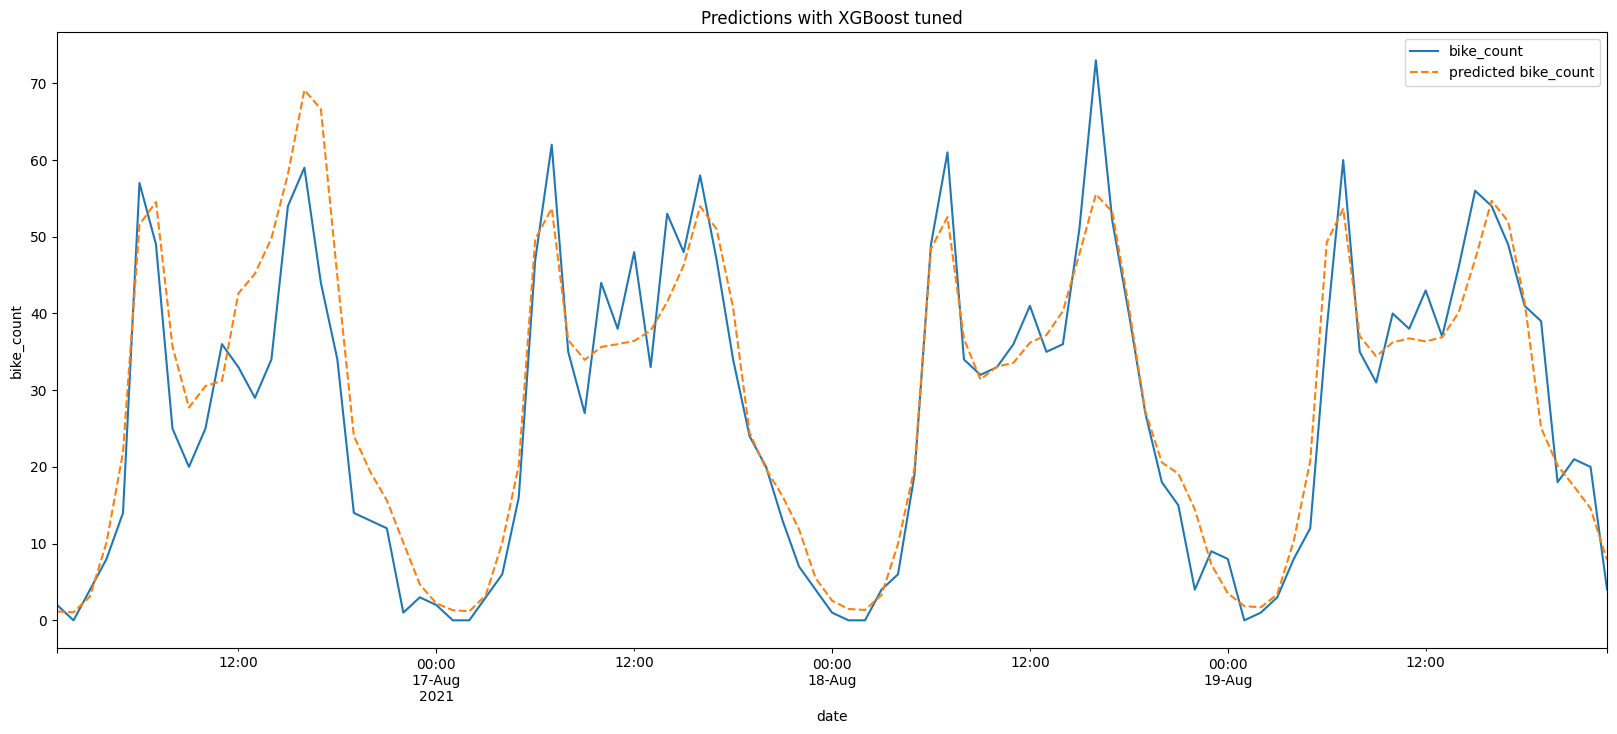

In [139]:
# Create mask to visualize on specific counter name and date
mask = (
    (X["counter_name"] == "18 quai de l'Hôtel de Ville SE-NO")
    & (X["date"] > pd.to_datetime("2021-08-16"))
    & (X["date"] < pd.to_datetime("2021/08/20"))
)

# Get the bike_count from the predicted log_bike_count
df_viz = X.loc[mask].copy()
df_viz["bike_count"] = np.exp(df_viz['log_bike_count']) - 1
df_viz["predicted bike_count"] = np.exp(df_viz['y_pred']) - 1


# Plot predicted bike count over bike_count
fig, ax = plt.subplots(figsize=(20, 8))

df_viz.plot(x="date", y="bike_count", ax=ax)
df_viz.plot(x="date", y="predicted bike_count", ax=ax, ls="--")
ax.set_title("Predictions with XGBoost tuned")
ax.set_ylabel("bike_count")

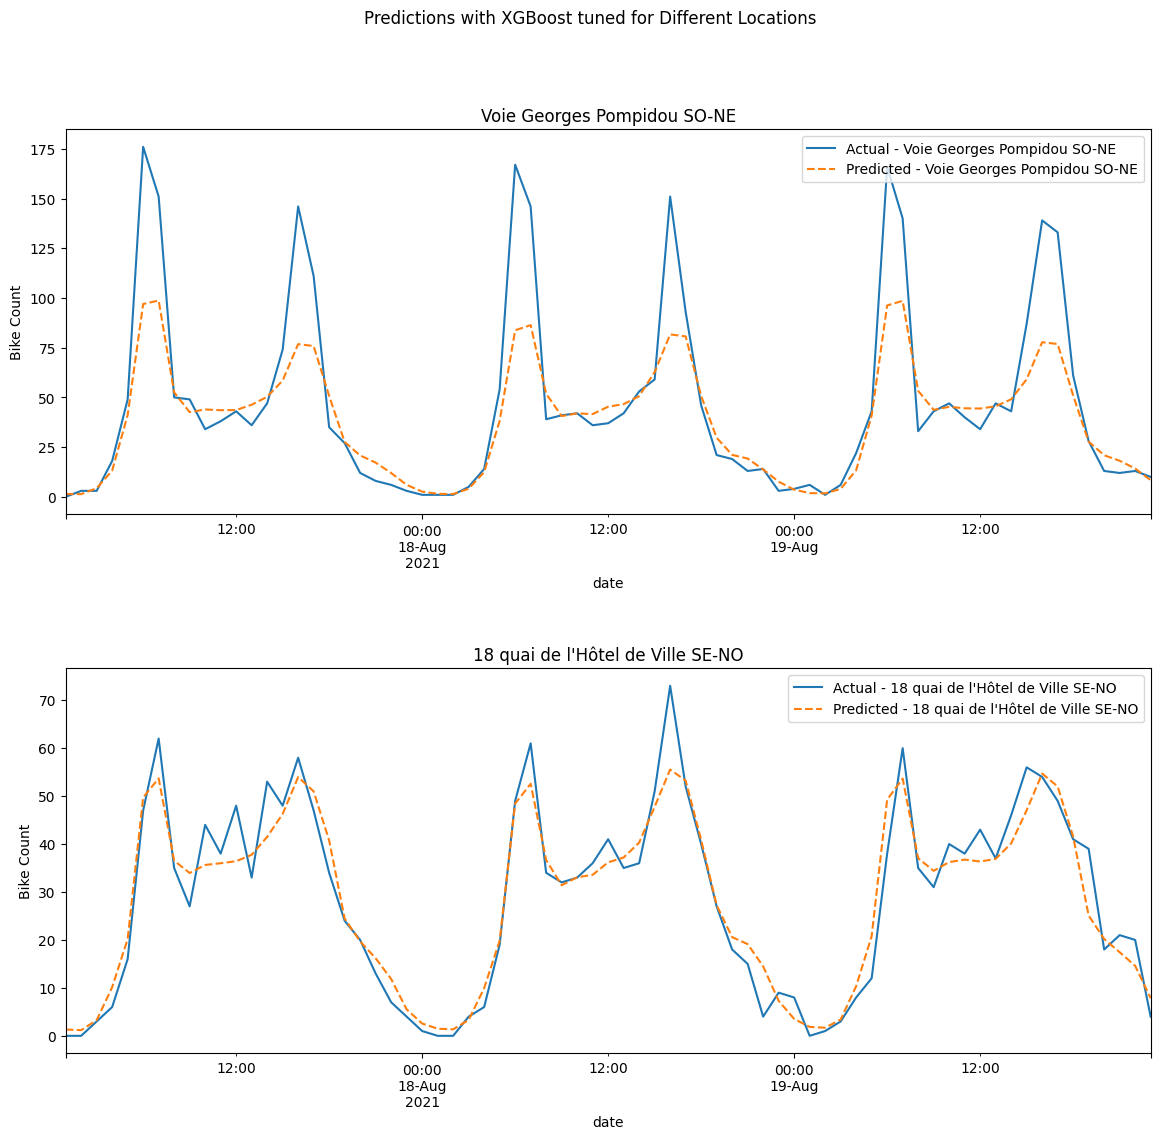

In [153]:
# Create mask for Voie Georges Pompidou SO-NE
mask_pompidou = (
    (X["counter_name"] == "Voie Georges Pompidou SO-NE")
    & (X["date"] > pd.to_datetime("2021-08-17"))
    & (X["date"] < pd.to_datetime("2021/08/20"))
)

# Create mask for 18 quai de l'Hôtel de Ville SE-NO
mask_hoteldeville = (
    (X["counter_name"] == "18 quai de l'Hôtel de Ville SE-NO")
    & (X["date"] > pd.to_datetime("2021-08-17"))
    & (X["date"] < pd.to_datetime("2021/08/20"))
)

# Applying masks and preparing data
df_viz_pompidou = X.loc[mask_pompidou].copy()
df_viz_pompidou["bike_count"] = np.exp(df_viz_pompidou['log_bike_count']) - 1
df_viz_pompidou["predicted bike_count"] = np.exp(df_viz_pompidou['y_pred']) - 1

df_viz_hoteldeville = X.loc[mask_hoteldeville].copy()
df_viz_hoteldeville["bike_count"] = np.exp(
    df_viz_hoteldeville['log_bike_count']) - 1
df_viz_hoteldeville["predicted bike_count"] = np.exp(
    df_viz_hoteldeville['y_pred']) - 1

# Creating subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot for Voie Georges Pompidou SO-NE on ax1
df_viz_pompidou.plot(x="date", y="bike_count", ax=ax1,
                     label="Actual - Voie Georges Pompidou SO-NE")
df_viz_pompidou.plot(x="date", y="predicted bike_count", ax=ax1,
                     ls="--", label="Predicted - Voie Georges Pompidou SO-NE")
ax1.set_title("Voie Georges Pompidou SO-NE")
ax1.set_ylabel("Bike Count")
ax1.legend()

# Plot for 18 quai de l'Hôtel de Ville SE-NO on ax2
df_viz_hoteldeville.plot(x="date", y="bike_count", ax=ax2,
                         label="Actual - 18 quai de l'Hôtel de Ville SE-NO")
df_viz_hoteldeville.plot(x="date", y="predicted bike_count", ax=ax2,
                         ls="--", label="Predicted - 18 quai de l'Hôtel de Ville SE-NO")
ax2.set_title("18 quai de l'Hôtel de Ville SE-NO")
ax2.set_ylabel("Bike Count")
ax2.legend()

plt.suptitle("Predictions with XGBoost tuned for Different Locations")
plt.subplots_adjust(hspace=0.4)
# You can change the file name and format (e.g., .png, .jpg, .pdf, etc.)
plt.savefig("bike_count_predictions.png")

plt.show()